In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
maxLengths = [20,55,148,403,1097,2981,2000000] #may need to update largest length
data_dir_2013 = path.join("Data", "clueweb-2013")
data_dir_wikt = path.join("Data", "wikt")

### Preparing data

In [2]:
#Initialise data dictionary with column names and empty lists
data = {"maxLength" : [], "stemmer" : [], "QID" : [], "nERR" : []}
data_avg = {"maxLength" : [], "stemmer" : [], "nERR" : []}
QID = np.arange(201,251)
for length in maxLengths:
    #Gather the data from each length file
    values = list()
    values_avg = list()
    queryTotal = 0
    with open(path.join(data_dir_2013,f"documentLength/nERR-{length}"), "r") as f:
        for line in f:
            if line[0].isalpha(): 
                queryTotal = 0
                continue
            queryTotal+=1
            if queryTotal > 50:
                values_avg.append(float(line.strip()))
                continue
            values.append(float(line.strip()))
    i = 0
    for stemmer in labels:
        data["nERR"].extend(values[50*i:50*(i+1)])
        data["maxLength"].extend([length for _ in QID])
        data["stemmer"].extend([stemmer for _ in QID])
        data["QID"].extend(QID)
        i+=1
    data_avg["nERR"].extend(values_avg)
    data_avg["maxLength"].extend([length for _ in labels])
    data_avg["stemmer"].extend(labels)
nERR_length = pd.DataFrame(data)
nERR_length_avg = pd.DataFrame(data_avg)
# display(nERR_length)
# display(nERR_length_avg)

### Average nERR-IA

In [3]:
target_data = nERR_length_avg[nERR_length_avg["maxLength"] < 100000]

best_nERR = list()
for length in np.unique(target_data["maxLength"]):
    selected_data = nERR_length_avg[nERR_length_avg["maxLength"] == length]
    best_nERR.append(selected_data["nERR"].max())

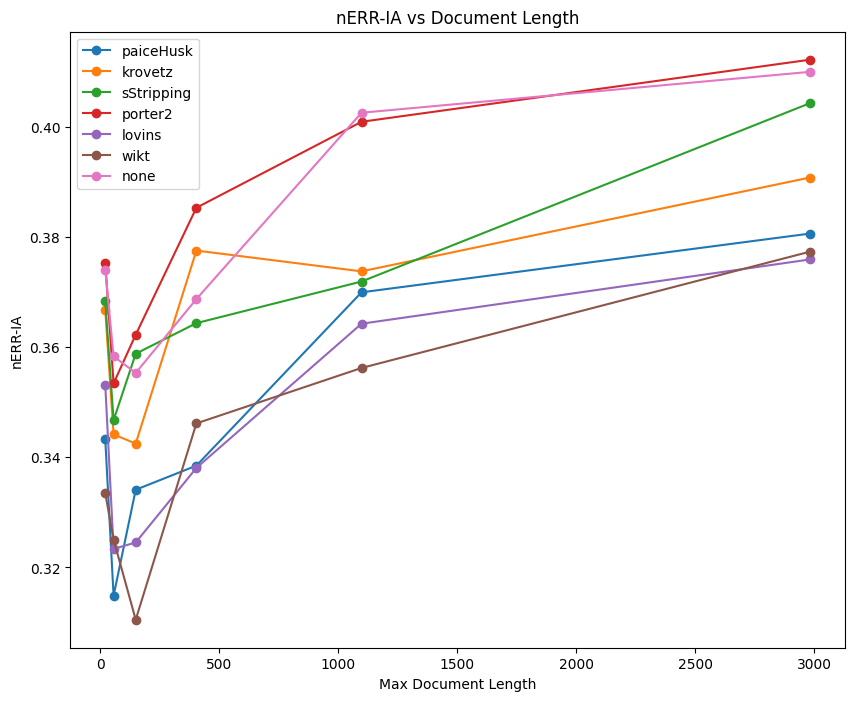

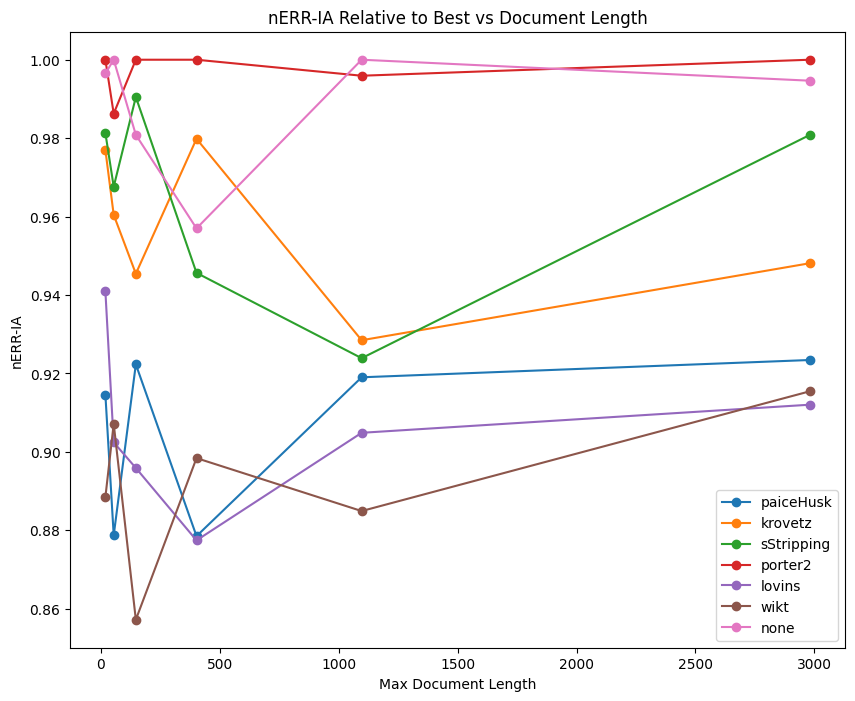

In [4]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    plt.plot(stemmer_data["maxLength"], stemmer_data["nERR"], "o-", label=stemmer)

plt.title("nERR-IA vs Document Length")
plt.xlabel("Max Document Length")
plt.ylabel("nERR-IA")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nERR"])/best_nERR
    plt.plot(stemmer_data["maxLength"], stemmer_values, "o-", label=stemmer)
    # plt.xscale("log")

plt.title("nERR-IA Relative to Best vs Document Length")
plt.xlabel("Max Document Length")
plt.ylabel("nERR-IA")
plt.legend()

In [ ]:
sns.catplot(data=nERR_length_avg, kind="bar", x="stemmer", y="nERR", col="maxLength", col_wrap=3)
plt.show()

### Results per query

In [ ]:
length = 403
nERR = nERR_length[nERR_length["maxLength"] == length]
# for q in QID:
#     q_nERR = nERR[nERR["QID"] == q]
#     # print(f"Query ID: {q}")
#     # display(q_nERR[q_nERR["nERR"] == q_nERR["nERR"].max()])
#     # display(q_nERR[q_nERR["nERR"] == q_nERR["nERR"].min()])
#     display(q_nERR[q_nERR["stemmer"] == "none"])
#     display(q_nERR[q_nERR["stemmer"] == "wikt"])
#     print()

display(nERR[nERR["QID"] == 232])
    

### Statistical Significance

In [ ]:
porter = list()
none = list()
for length in maxLengths:
    p = list()
    n = list()
    target_data = nERR_length[nERR_length["maxLength"] == length]
    p = target_data[target_data["stemmer"] == "porter2"].loc[:,"nERR"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nERR"].tolist()
    print(f"Max length: {length} {stats.ttest_rel(p,n)}")
    porter.extend(p)
    none.extend(n)
print()
print(f"Overall: {stats.ttest_rel(porter,none)}")


### Linguistic Accuracy

In [ ]:
nERR_fmeasure = nERR_length_avg[nERR_length_avg["stemmer"] != "none"]

averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
averages.append(1)
fmeasures = list()
for length in maxLengths:
    fmeasures.extend(averages)
nERR_fmeasure["fmeasure"] = fmeasures

In [ ]:
MARKERS = ["o","^","s","*","d","x"]
COLORS = ["tab:red","tab:orange","tab:green","tab:blue","tab:purple","tab:pink"]

graph = sns.lmplot(nERR_length_avg, x="nERR", y="fmeasure", hue="stemmer", markers=MARKERS, palette=COLORS, col="maxLength", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False)

for document_length, ax in zip(np.unique(nERR_length_avg["maxLength"]), graph.axes):
    target_data = nERR_fmeasure[nERR_length_avg["maxLength"] == document_length]
    sns.regplot(target_data, x="nERR", y="fmeasure", scatter=False, ci=None, ax=ax)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
for length in maxLengths:
    x = nERR_fmeasure[nERR_fmeasure["maxLength"] == length]["nERR"].to_numpy()
    y = nERR_fmeasure[nERR_fmeasure["maxLength"] == length]["fmeasure"].to_numpy()
    print(f"Length: {length} {stats.pearsonr(x,y)}")
x = nERR_length_avg["nERR"].to_numpy()
y = nERR_length_avg["fmeasure"].to_numpy()
print(f"Overall: {stats.pearsonr(x,y)}")